<a href="https://colab.research.google.com/github/cosmo3xplorer/BrainTumour_Detection/blob/main/Brain_Tumor_Classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import keras
import tensorflow as tf
import os, gc, pathlib
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision.all import *
from fastai.tabular.all import *
from fastai.text.all import *
#from fastai.medical.imaging import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.models import *
import torchvision.models as models
from fastai.callback.schedule import lr_find
from fastai.callback.schedule import *
from matplotlib import pyplot as plt
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 

In [2]:
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/samples"))
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/samples/Brain_Tumor"
os.listdir(f'{DATA_DIR}')

['Brain_Tumor', 'no', 'yes', 'pred']


['no', 'yes', 'models']

In [120]:
data = ImageDataLoaders.from_folder(DATA_DIR, train=".", 
                                    valid_pct=0.2,
                                    ds_tfms=aug_transforms(mult=1.0, do_flip=True, flip_vert=True, 
                                    max_warp=0, max_rotate=10.0, 
                                    max_zoom=1.1, max_lighting=0.2,
                                    p_affine=0.75, mode='bilinear',
                                    pad_mode='reflection',
                                    align_corners=True, min_scale=1.0),
                                    item_tfms=Resize(224),
                                    bs=64,
                                    val_bs=None,
                                    num_workers=0,
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))

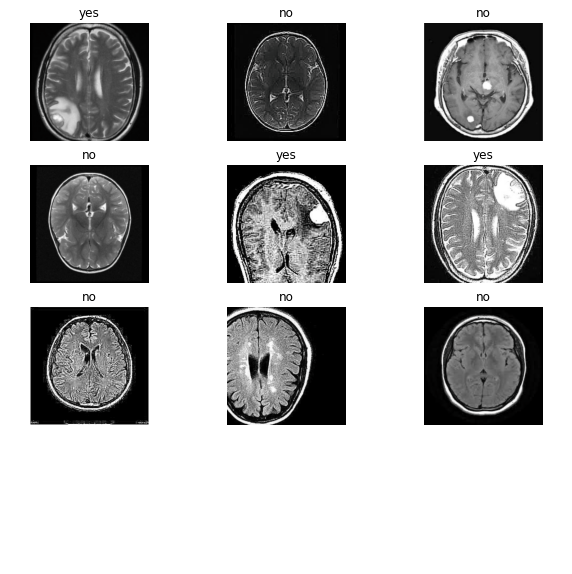

In [121]:
data.show_batch(nrows=4, figsize=(10,10))

In [122]:
model = nn.Sequential(
    nn.Sequential(
        nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),
                nn.AdaptiveAvgPool2d(1),
                nn.AdaptiveMaxPool2d(1)             
        )
    ),
    nn.Sequential(
                nn.Flatten(),
                nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Dropout(p=0.25, inplace=False),
                nn.Linear(in_features=512, out_features=256, bias=False),
                nn.ReLU(),
                nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Dropout(p=0.5, inplace=False),
                nn.Linear(in_features=256, out_features=2, bias=False)
    )
)


In [123]:
learner = Learner(data, model, metrics=[accuracy, error_rate])

In [124]:
learner.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 224 x 224 
Conv2d                                    1792       True      
ReLU                                                           
Conv2d                                    36928      True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 112 x 11 
Conv2d                                    73856      True      
ReLU                                                           
Conv2d                                    147584     True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 256

SuggestedLRs(valley=0.0003311311302240938)

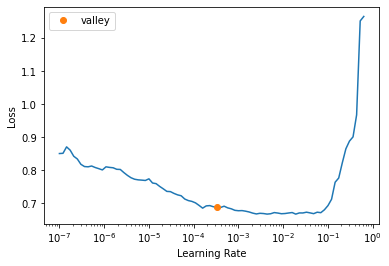

In [126]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.646731,0.686551,0.490000,0.510000,00:47
1,0.606457,0.569797,0.705000,0.295000,00:46
2,0.560143,0.793575,0.630000,0.370000,00:46
3,0.510791,0.489548,0.790000,0.210000,00:46
4,0.456320,0.558353,0.740000,0.260000,00:46
5,0.422056,0.590451,0.695000,0.305000,00:47
6,0.379828,0.781892,0.691667,0.308333,00:46
7,0.336794,0.328953,0.881667,0.118333,00:47
8,0.302973,0.258106,0.903333,0.096667,00:47
9,0.281183,0.250141,0.913333,0.086667,00:46


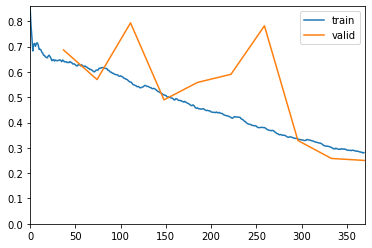

In [127]:
learner.fit_one_cycle(10, lr_max=slice(3.3e-4), cbs=[ShowGraphCallback()])

In [128]:
learner.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

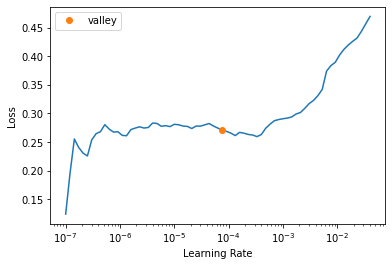

In [129]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.269974,0.248068,0.916667,0.083333,00:46
1,0.265982,0.245841,0.920000,0.080000,00:46
2,0.252708,0.282038,0.891667,0.108333,00:46
3,0.241891,0.684521,0.768333,0.231667,00:47
4,0.235017,0.313881,0.876667,0.123333,00:47
5,0.210769,0.194165,0.923333,0.076667,00:47
6,0.195517,0.186109,0.921667,0.078333,00:46
7,0.182622,0.176048,0.926667,0.073333,00:46


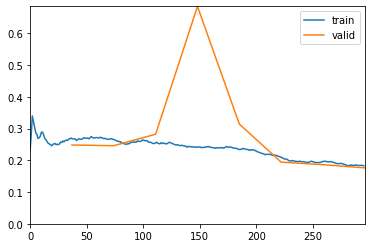

In [130]:
learner.fit_one_cycle(8, lr_max=slice(7.59e-5), cbs=[ShowGraphCallback()])

In [131]:
learner.export("/content/drive/MyDrive/Colab Notebooks/pretrained_model/cnn/btc4_final.pkl")

In [132]:
interp = ClassificationInterpretation.from_learner(learner)

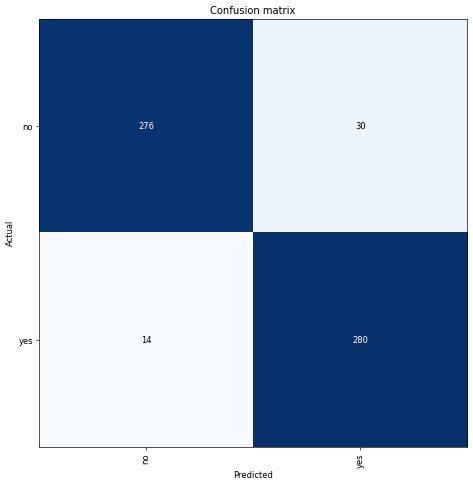

In [134]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)